<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Momentum</h1>

<h2>Table of Contents</h2>
<p>In this lab, you will deal with several problems associated with optimization and see how momentum can improve your results.</p>
<ul>
    <li><a href="#Saddle">Saddle Points</a></li>
    <li><a href="#Minima">Local Minima</a></li>
    <li><a href="#Noise"> Noise </a></li>
</ul>

<p>Estimated Time Needed: <b>25 min</b></p>
<hr>

<h2>Preparation</h2>

Import the following libraries that you'll use for this lab:

In [1]:
## These are the libraries that will be used for this lab.

import torch 
import torch.nn as nn
import matplotlib.pylab as plt
import numpy as np

torch.manual_seed(0)

This function will plot a cubic function and the parameter values obtained via Gradient Descent.

In [2]:
## utils

def prep_loss(w, ws, fun):
  losses = []
  for w.state_dict()['linear.weight'][0] in ws:
        losses.append(fun(w(torch.tensor([[1.0]]))).item())
  return losses

def plot_(ws, parameter, losses, loss_list, label='parameter values', 
          marker='ro', objfun=True):
  if objfun:
     plt.plot(ws.numpy(), losses, label='objective function')
  plt.plot(parameter, loss_list, marker, label=label)
  plt.xlabel('w')
  plt.ylabel('l(w)')
  plt.legend()
  return

In [3]:
## Plot the cubic

def plot_cubic(w, optimizer, n_epochs=10):
    ## parameter values 
    ws = torch.arange(-4, 4, 0.1)
    ## plot the loss fuction
    losses = prep_loss(w, ws, fun=cubic)
    w.state_dict()['linear.weight'][0] = 4.0
    parameter, loss_list = [], []
    ## Use PyTorch custom module to implement a polynomial function
    for n in range(n_epochs):
        optimizer.zero_grad() 
        loss = cubic(w(torch.tensor([[1.0]])))
        loss_list.append(loss)
        parameter.append(w.state_dict()['linear.weight'][0].detach().data.item())
        loss.backward()
        optimizer.step()
    #
    plot_(ws, parameter, losses, loss_list, label='parameter values')
    return

This function will plot a 4th order function and the parameter values obtained via Gradient Descent. You can also add Gaussian noise with a standard deviation determined by the parameter <code>std</code>.

In [4]:
## Plot the fourth order function and the parameter values

def plot_fourth_order(w, optimizer, 
                      n_epochs=100,
                      std=0, color='r', paramlabel='parameter values', 
                      objfun=True):
    ws = torch.arange(-4, 6, 0.1)
    losses = prep_loss(w, ws, fun=fourth_order)
    w.state_dict()['linear.weight'][0] = 6
    parameter, loss_list = [], []
    
    for n in range(n_epochs):
        optimizer.zero_grad()
        loss = fourth_order(w(torch.tensor([[1.0]]))) + std * torch.randn(1, 1)
        loss_list.append(loss)
        parameter.append(w.state_dict()['linear.weight'][0].detach().data.item())
        loss.backward()
        optimizer.step()
    
    # Plotting
    plot_(ws, parameter, losses, loss_list, label='parameter values')
    return

This is a custom module. It will behave like a single parameter value. We do it this way so we can use PyTorch's build-in optimizers .

In [5]:
## Create a linear model

class OneParam(nn.Module):
    ## Constructor
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, bias=False)
        
    ## Prediction
    def forward(self, x):
        return self.linear(x) # yhat

We create an object <code>w</code>, when we call the object with an input of one, it will behave like an individual parameter value. i.e <code>w(1)</code> is analogous to $w$ 

In [6]:
## Create a one_param object

w = OneParam(1, 1)

<h2 id="Saddle">Saddle Points</h2>

Let's create a cubic function with Saddle points 

In [7]:
## Define a function to output a cubic 

def cubic(yhat):
    return yhat ** 3

We create an optimizer with no momentum term 

In [8]:
# Create a optimizer without momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.01, momentum=0)

We run several iterations of stochastic gradient descent and plot the results.  
**We see the parameter values get stuck in the saddle point**.

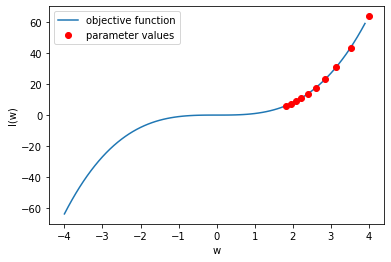

In [9]:
## Plot the model

plot_cubic(w, optimizer)

We create an optimizer with **momentum term of 0.9**

In [10]:
## Create a optimizer with momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.01, momentum=0.9)

We run several iterations of stochastic gradient descent with momentum and plot the results.  
**We see the parameter values do NOT get stuck in the saddle point**.

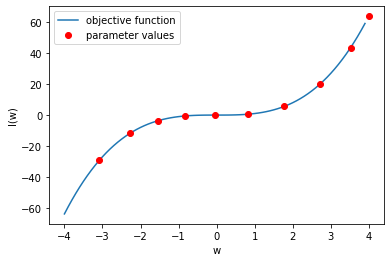

In [11]:
## Plot the model

plot_cubic(w, optimizer)

<h2 id="Minima">Local Minima</h2>

In this section, we will create a fourth order polynomial with a local minimum at $4$ and a global minimum at $2$.  
We will then see how the momentum parameter affects convergence to a global minimum.  The fourth order polynomial is given by:

In [12]:
## Create a function to calculate the fourth order polynomial 

def fourth_order(yhat): 
    return torch.mean(2 * (yhat ** 4) - 9 * (yhat ** 3) - 21 * (yhat ** 2) + 88 * yhat + 48)

We create an optimizer with *no momentum term*.  
We run several iterations of stochastic gradient descent and plot the results.  
**We see the parameter values get stuck in the local minimum**.

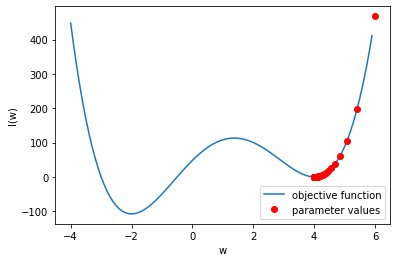

In [13]:
## Make the prediction without momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.001)
plot_fourth_order(w, optimizer)

We create an optimizer with a **momentum term of 0.9**.  
We run several iterations of stochastic gradient descent and plot the results.  
We see the parameter values reach a global minimum.

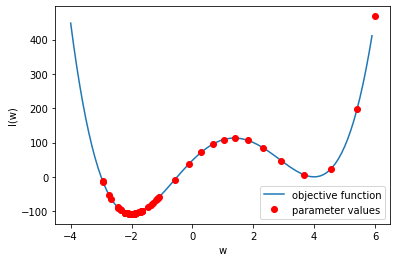

In [14]:
## Make the prediction with momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.001, momentum=0.9)
plot_fourth_order(w, optimizer)

<h2 id="Noise">Noise</h2>

In this section, we will create a fourth order polynomial with a local minimum at 4 and a global minimum a -2, but we will add noise to the function when the Gradient is calculated. We will then see how the momentum parameter affects convergence to a global minimum. 

with no momentum, we get stuck in a local minimum 

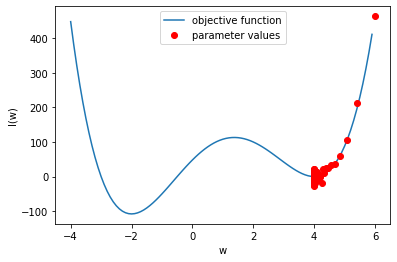

In [15]:
## Make the prediction without momentum when there is noise

optimizer = torch.optim.SGD(w.parameters(), lr=0.001)
plot_fourth_order(w, optimizer, std=10)

with  momentum, we get to the global  minimum 

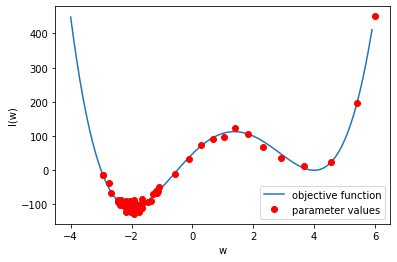

In [16]:
## Make the prediction with momentum when there is noise

optimizer = torch.optim.SGD(w.parameters(), lr=0.001, momentum=0.9)
plot_fourth_order(w, optimizer, std=10)

<h3>Practice</h3>

- Create two <code> SGD</code>  objects with a learning rate of <code> 0.001</code>. 
- Use the default momentum parameter value  for one and a value of <code> 0.9</code> for the second. 
- Use the function <code>plot_fourth_order</code> with an <code>std=100</code>, to plot the different steps of each. 

**Make sure you run the function on two independent cells**.

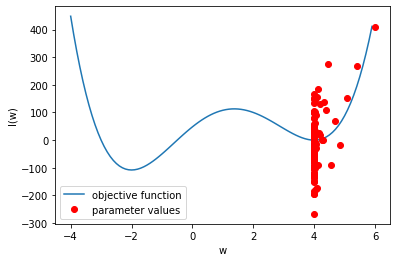

In [19]:
# Practice: Create two SGD optimizer with lr = 0.001, and one without momentum and 
# the other with momentum = 0.9. Plot the result out.

# Type your code here
w = OneParam(1, 1)

lr = 0.001
optimizer_def = torch.optim.SGD(w.parameters(), lr=lr)
optimizer_0_9 = torch.optim.SGD(w.parameters(), lr=lr, momentum=0.9)

plot_fourth_order(w, optimizer_def, std=100, 
                  paramlabel='parms values with optimizer (def)', 
                  objfun=False)

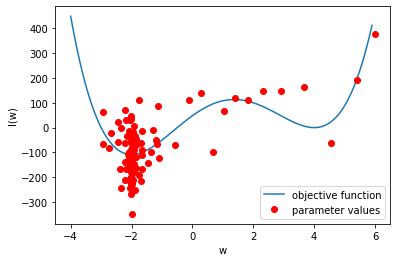

In [20]:
plot_fourth_order(w, optimizer_0_9, std=100,
                  paramlabel='parms values with optimizer (mom: 0.9)', 
                  objfun=False)

Double-click <b>here</b> for the solution.

<!-- 
optimizer1 = torch.optim.SGD(w.parameters(), lr = 0.001)
plot_fourth_order(w, optimizer1, std = 100, color = 'black', paramlabel = 'parameter values with optimizer 1')

optimizer2 = torch.optim.SGD(w.parameters(), lr = 0.001, momentum = 0.9)
plot_fourth_order(w, optimizer2, std = 100, color = 'red', paramlabel = 'parameter values with optimizer 2', objfun = False)
 -->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a> 

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.